<a href="https://colab.research.google.com/github/RenatoCes/Trabalho_Final_IA/blob/main/Reconhecimento_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless
!pip install face_recognition

Menu:
1. Registrar novo rosto
2. Reconhecer rostos em tempo real
3. Sair
Escolha uma opção: 2


<IPython.core.display.Javascript object>

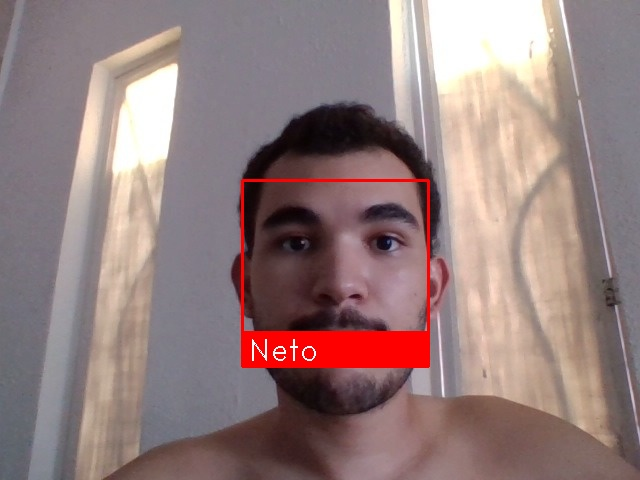

Menu:
1. Registrar novo rosto
2. Reconhecer rostos em tempo real
3. Sair
Escolha uma opção: 3
Saindo...


In [ ]:
import face_recognition
import cv2
import numpy as np
import os
import pickle
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

class CameraCapture:
    @staticmethod
    def capture_image():
        js = Javascript('''
        async function captureImage() {
          const div = document.createElement('div');
          const video = document.createElement('video');
          const button = document.createElement('button');
          button.textContent = 'Capture Image';
          div.appendChild(video);
          div.appendChild(button);
          document.body.appendChild(div);
          const stream = await navigator.mediaDevices.getUserMedia({video: true});
          video.srcObject = stream;
          await video.play();
          await new Promise((resolve) => button.onclick = resolve);
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getTracks().forEach(track => track.stop());
          div.remove();
          return canvas.toDataURL('image/jpeg').replace(/^data:image\\/jpeg;base64,/, '');
        }
        ''')
        display(js)
        data = eval_js('captureImage()')
        binary = b64decode(data)
        np_data = np.frombuffer(binary, np.uint8)
        img = cv2.imdecode(np_data, cv2.IMREAD_COLOR)
        return img

class FaceRecognitionSystem:
    registro_dir = '/content/Registro'

    def __init__(self):
        if not os.path.exists(self.registro_dir):
            os.makedirs(self.registro_dir)

    def registrar_rosto(self, nome):
        img = CameraCapture.capture_image()
        if img is None:
            print("Falha ao capturar imagem da câmera.")
            return

        rgb_frame = np.ascontiguousarray(img[:, :, ::-1])
        face_locations = face_recognition.face_locations(rgb_frame)
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

        if face_encodings:
            rosto_enc = face_encodings[0]
            rosto_file = os.path.join(self.registro_dir, f"{nome}.pkl")
            with open(rosto_file, 'wb') as f:
                pickle.dump(rosto_enc, f)
            print(f"Rosto de {nome} registrado com sucesso!")
        else:
            print("Nenhum rosto detectado. Tente novamente.")

    def carregar_rostos_registrados(self):
        rostos_registrados = {}
        for file_name in os.listdir(self.registro_dir):
            if file_name.endswith('.pkl'):
                nome = file_name.split('.')[0]
                rosto_file = os.path.join(self.registro_dir, file_name)
                with open(rosto_file, 'rb') as f:
                    rostos_registrados[nome] = pickle.load(f)
        return rostos_registrados

    def reconhecer_rostos(self):
        rostos_registrados = self.carregar_rostos_registrados()
        known_face_encodings = list(rostos_registrados.values())
        known_face_names = list(rostos_registrados.keys())

        img = CameraCapture.capture_image()
        if img is None:
            print("Falha ao capturar imagem da câmera.")
            return

        rgb_frame = np.ascontiguousarray(img[:, :, ::-1])

        face_locations = face_recognition.face_locations(rgb_frame)
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)

        for (top, right, bottom, left), name in zip(face_locations, face_names):
            cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
            cv2.rectangle(img, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(img, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

        _, im_buf_arr = cv2.imencode('.jpg', img)
        im_buf_arr = im_buf_arr.tobytes()
        display(Image(data=im_buf_arr))

class Menu:
    def __init__(self):
        self.face_recognition_system = FaceRecognitionSystem()

    def show(self):
        while True:
            print("Menu:")
            print("1. Registrar novo rosto")
            print("2. Reconhecer rostos em tempo real")
            print("3. Sair")
            escolha = input("Escolha uma opção: ")

            if escolha == '1':
                nome = input("Digite o nome do indivíduo: ")
                self.face_recognition_system.registrar_rosto(nome)
            elif escolha == '2':
                self.face_recognition_system.reconhecer_rostos()
            elif escolha == '3':
                print("Saindo...")
                break
            else:
                print("Opção inválida. Tente novamente.")
menu = Menu()
menu.show()
